# U-Net with Pretrained MobileNetV2 as Encoder

## What is U-Net
Paper: <a href="https://arxiv.org/abs/1505.04597"> https://arxiv.org/abs/1505.04597 </a>

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.

<img src="images/u-net-architecture.png">

<br/>
UNet Architecture has 3 parts:
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h3>Downsampling Path: </h3>
 <ul>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li>
    <li>At each downsampling step we double the number of feature channels.</li>
</ul>

<h3>Upsampling Path: </h3>
<ul>
    <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ul>

<h3> Skip Connection: </h3>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h3> Final Layer: </h3>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.
<br/> <br/> <br/>
<hr>

## What is MobileNetV2
Paper: <a href="https://arxiv.org/pdf/1801.04381.pdf"> https://arxiv.org/pdf/1801.04381.pdf </a>

MobileNetV2 is a architecture that is optimized for mobile devices. It improves the state of the art performance of mobile models on multiple tasks and benchmarks as well as across a spectrum of different model
sizes.

<img src="images/MobileNetV2 architecture.png" style="height:400px; ">

The MobileNetV2 is used for the encoder/downsampling path of the U-Net (the left half of the U)
<br/> <br/> <br/>
<hr>

## What are the Advantages of using a MobileNetV2 as Pretrained Encoder

<ul>
    <li> MobileNetV2 has less parameters, due to which it is easy to train. </li>
    <li> Using a pretrained encoder helps the model to converge much faster in comparison to the non-pretrained model. </li>
    <li> A pretrained encoder helps the model to achieve high performance as compared to non-pretrained model.</li>
</ul>
<br/>
<hr>

## Importing Libraries and Functions

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [ ]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_file_path = r'/content/drive/My Drive/Signals and Systems Research Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Seeding

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

In [ ]:
IMAGE_SIZE = 256
EPOCHS = 200 #30
BATCH = 8
LR = 1e-4

PATH = data_file_path + 'combined_dataset_checked/'#'VLT_combined_100_105/'#"CVC-612/"
save_dir = 'combined_dataset_checked_data_no_aug_mobilenetv2'
print(PATH)

/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/


## Dataset
You can download the dataset from <a href="https://polyp.grand-challenge.org/CVCClinicDB/">here</a> or from directly from the <a href="https://www.dropbox.com/s/p5qe9eotetjnbmq/CVC-ClinicDB.rar?dl=0">Dropbox</a>.

<br/>
Spliting the data into training, validation and testing with 80:10:10 ratio.

In [ ]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "Original/*")))
    masks = sorted(glob(os.path.join(path, "Ground_Truth/*")))
    # images = sorted(glob(os.path.join(path, "images/*")))
    # masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)
    print(total_size)
    # train_x, valid_x = train_test_split(images, test_size=split, train_size= (1-split), random_state=42)
    # train_y, valid_y = train_test_split(masks, test_size=split,train_size= (1-split), random_state=42)

    # train_x, test_x = train_test_split(train_x, test_size=split,train_size= (1-split), random_state=42)
    # train_y, test_y = train_test_split(train_y, test_size=split, train_size= (1-split),random_state=42)
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

Reading the images and masks

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

Building the tf.data pipeline for training, validation and testing dataset.

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.1)
])

def augment(image, mask, seed):
    image = tf.keras.layers.RandomFlip()(image, seed=seed)
    image = tf.keras.layers.RandomZoom(0.1)(image, seed=seed)
    image = tf.keras.layers.RandomRotation(0.1)(image, seed=seed)
    image = tf.keras.layers.RandomContrast(0.1)(image, seed=seed)
    image = tf.keras.layers.RandomBrightness(0.1)(image, seed=seed)
    image = tf.keras.layers.RandomFieldDistortion(0.1)(image, seed=seed)

    mask = tf.keras.layers.RandomFlip()(mask, seed=seed)
    mask = tf.keras.layers.RandomZoom(0.1)(mask, seed=seed)
    mask = tf.keras.layers.RandomRotation(0.1)(mask, seed=seed)
    mask = tf.keras.layers.RandomContrast(0.1)(mask, seed=seed)
    mask = tf.keras.layers.RandomBrightness(0.1)(mask, seed=seed)
    mask = tf.keras.layers.RandomFieldDistortion(0.1)(mask, seed=seed)
    return image, mask


def aug_tf_parse(x,y):
    def _parse(x, y):
      x = read_image(x)
      y = read_mask(y)
      return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    seed = random.randrange(2**32)
    x = data_augmentation(x, seed=seed)
    y = data_augmentation(y, seed=seed)
    # x, y = augment(x, y, seed)
    # x, y = data_augmentation(x, y, seed = seed)
    # x, y = augment(x,y)
    # x = data_augmentation(x)
    # y = data_augmentation(y)
    return x, y

def aug_tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(aug_tf_parse, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    return dataset


In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

3523
Training data:  2819
Validation data:  352
Testing data:  352


In [ ]:
train_y

['/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/1443.png',
 '/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/2455.png',
 '/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/399.png',
 '/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/2921.png',
 '/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/3625.png',
 '/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/2633.png',
 '/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/2668.png',
 '/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/2840.png',
 '/content/drive/My Drive/Signals and Systems Research Project/combined_dataset_checked/Ground_Truth/129.

In [ ]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

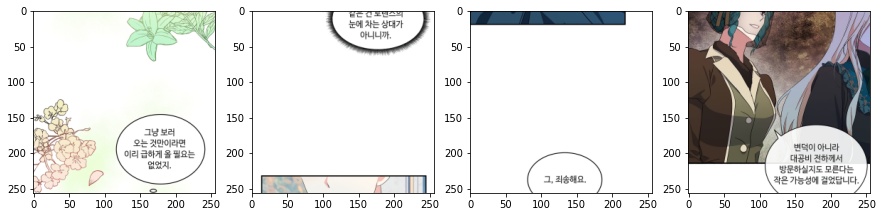

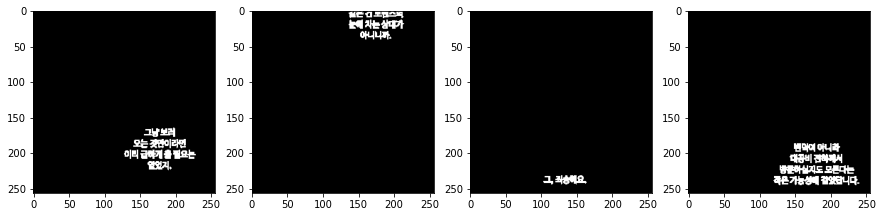

In [ ]:
fig = plt.figure(figsize=(15, 15))

# fig_num = 6
# for i in range(fig_num):
#   a = fig.add_subplot(1, fig_num, i)
#   imgplot = plt.imshow(read_and_rgb(train_x[i]))
#   imgplot.set_clim(0.0, 0.7)
# fig = plt.figure(figsize=(15, 15))
# for i in range(fig_num):
#   a = fig.add_subplot(1, fig_num, i)
#   imgplot = plt.imshow(read_and_rgb(train_y[i]))
#   imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)



## Model

In [ ]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
model = model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 16  64          ['Conv1[0][0]']                  
                                )                                                           

## Metrics

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Training

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

# data_aug_train_dataset = aug_tf_dataset(train_x, train_y, batch=BATCH)


In [ ]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/200
353/353 [==============================] - 55s 119ms/step - loss: 0.8283 - dice_coef: 0.1720 - recall_2: 0.9335 - precision_2: 0.3594 - val_loss: 0.8214 - val_dice_coef: 0.1786 - val_recall_2: 0.9605 - val_precision_2: 0.5239 - lr: 1.0000e-04
Epoch 2/200
353/353 [==============================] - 40s 114ms/step - loss: 0.7003 - dice_coef: 0.2999 - recall_2: 0.9584 - precision_2: 0.6720 - val_loss: 0.6856 - val_dice_coef: 0.3144 - val_recall_2: 0.9282 - val_precision_2: 0.7557 - lr: 1.0000e-04
Epoch 3/200
353/353 [==============================] - 40s 114ms/step - loss: 0.5788 - dice_coef: 0.4215 - recall_2: 0.9567 - precision_2: 0.7768 - val_loss: 0.5587 - val_dice_coef: 0.4413 - val_recall_2: 0.9255 - val_precision_2: 0.8325 - lr: 1.0000e-04
Epoch 4/200
353/353 [==============================] - 40s 114ms/step - loss: 0.4515 - dice_coef: 0.5487 - recall_2: 0.9518 - precision_2: 0.8423 - val_loss: 0.4404 - val_dice_coef: 0.5596 - val_recall_2: 0.8994 - val_precision_2: 0.88

## Evaluation

In [ ]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

44/44 [==============================] - 3s 69ms/step - loss: 0.0727 - dice_coef: 0.9273 - recall_2: 0.9109 - precision_2: 0.9508


[0.07269363105297089,
 0.9273062348365784,
 0.9108654856681824,
 0.9508495330810547]

## Results

In [ ]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [ ]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
if not os.path.exists(data_file_path+ '{}'.format(save_dir)):
  os.makedirs(data_file_path+ '{}'.format(save_dir))

1/1 [==============================] - 0s 20ms/step


<ipython-input-117-01e13f4b295a>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


1/1 [==============================] - 0s 29ms/step


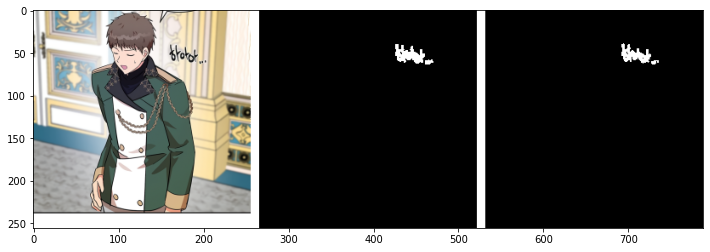

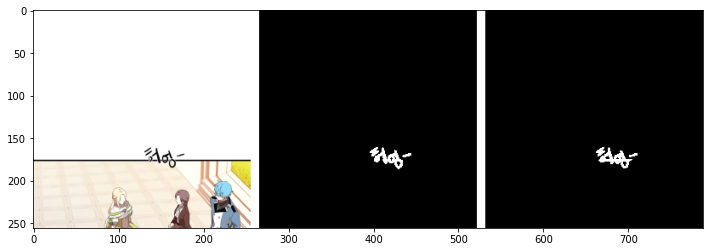

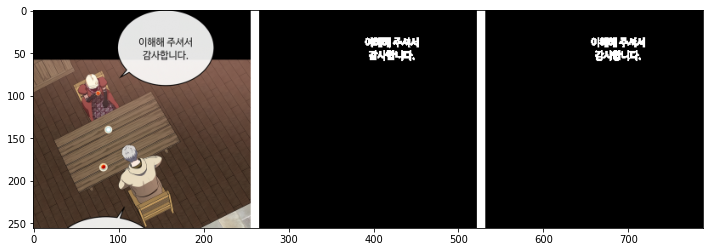

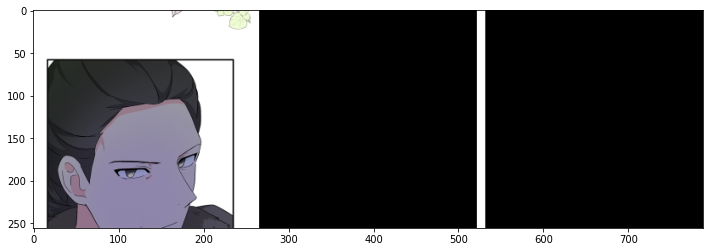

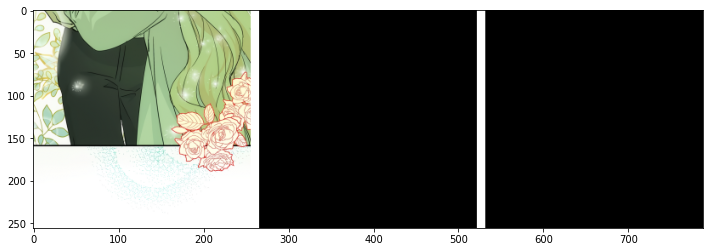

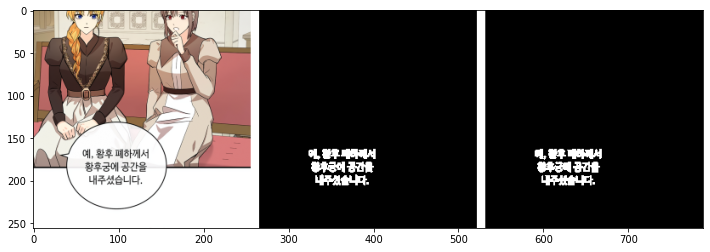

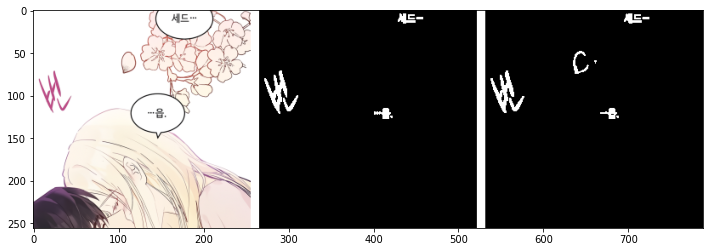

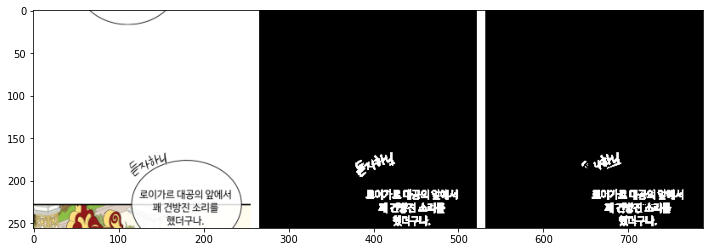

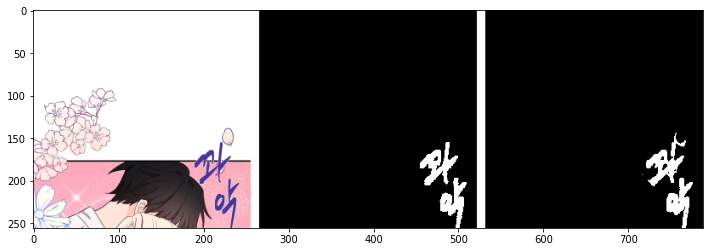

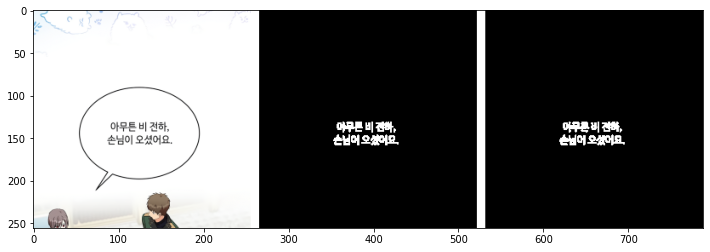

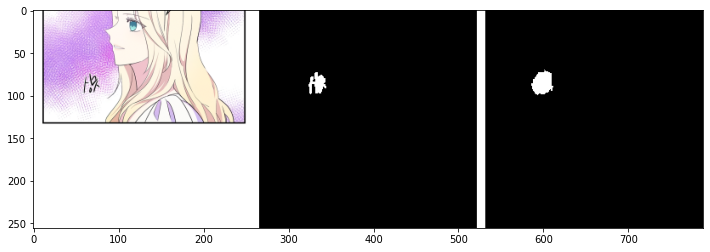

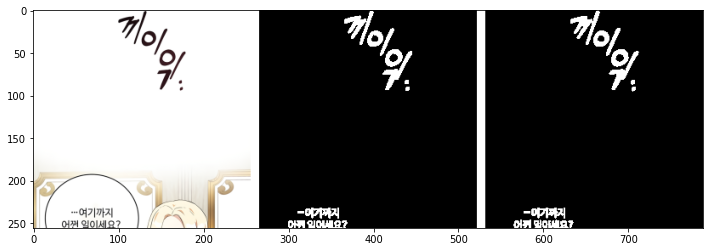

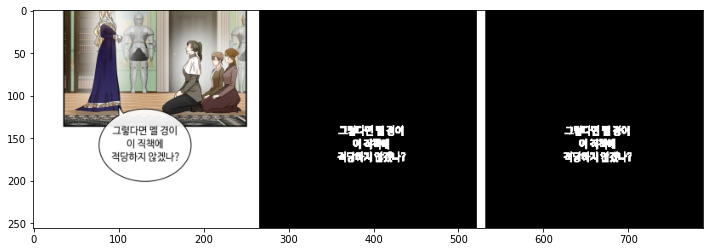

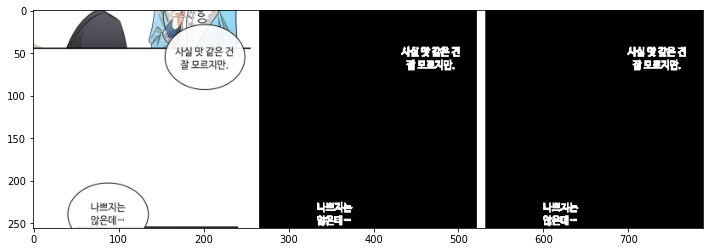

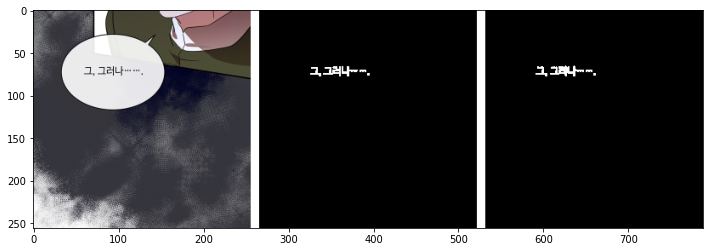

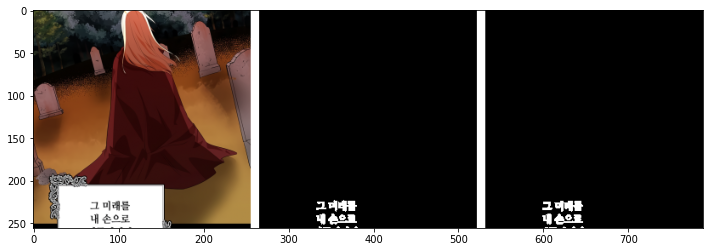

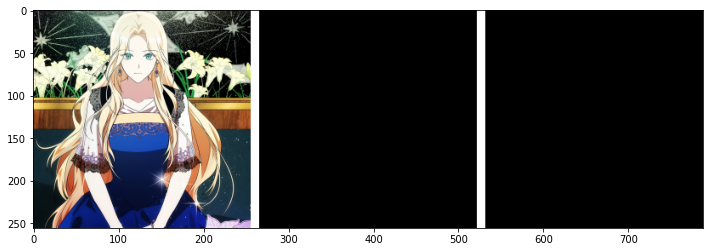

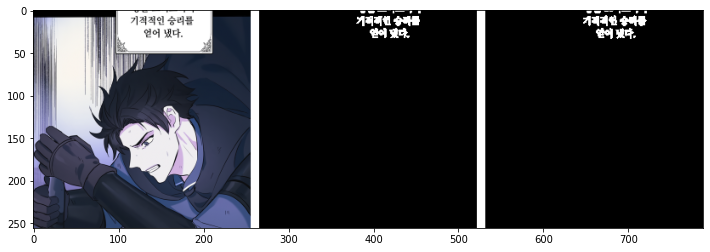

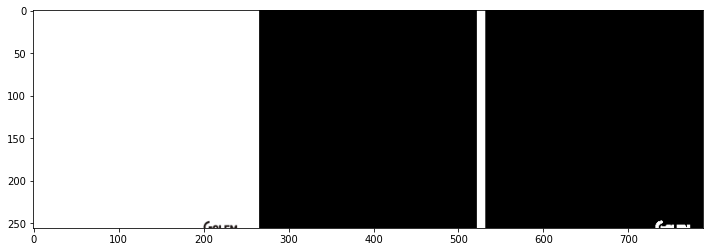

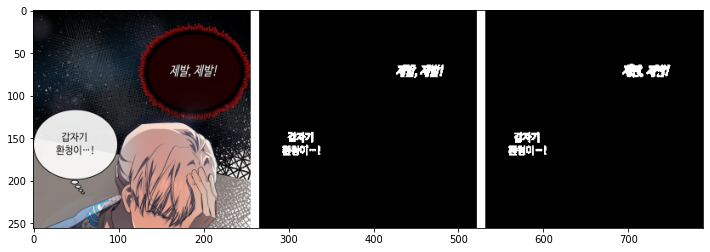

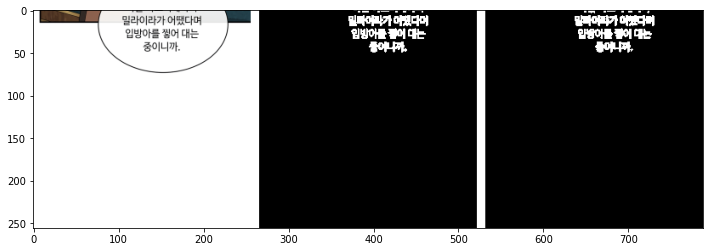

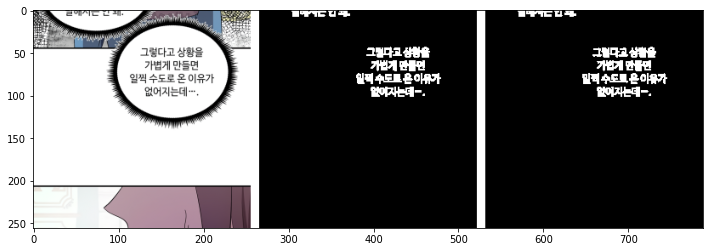

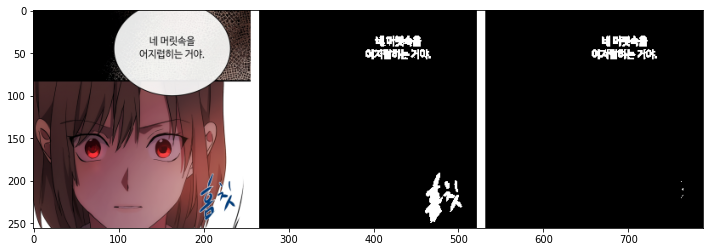

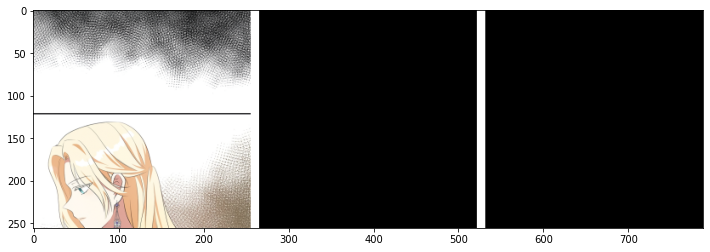

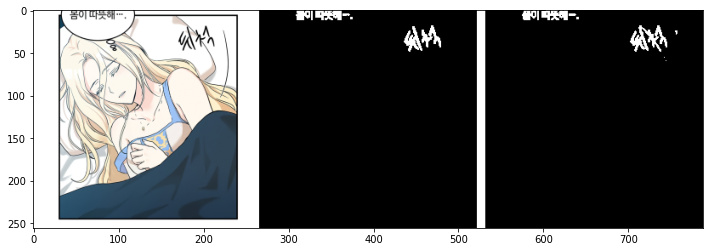

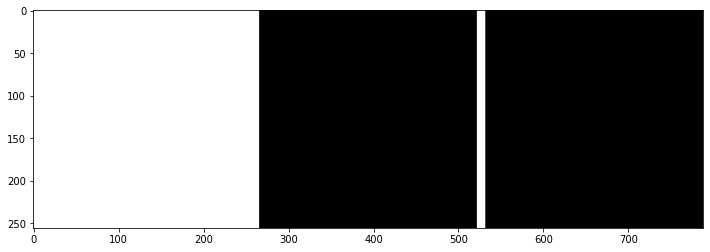

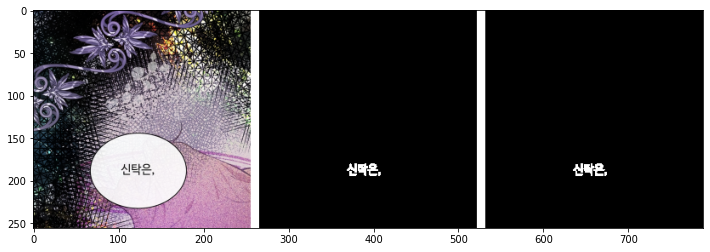

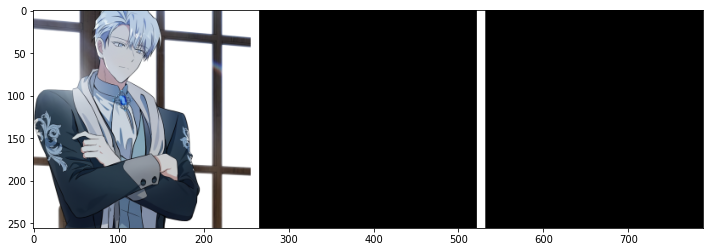

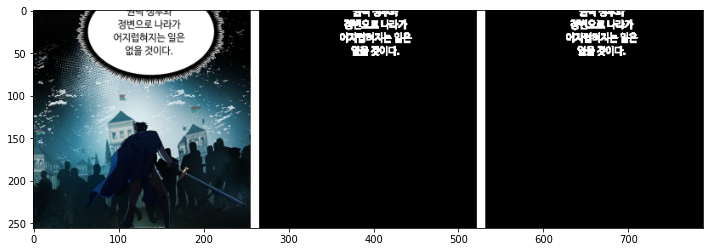

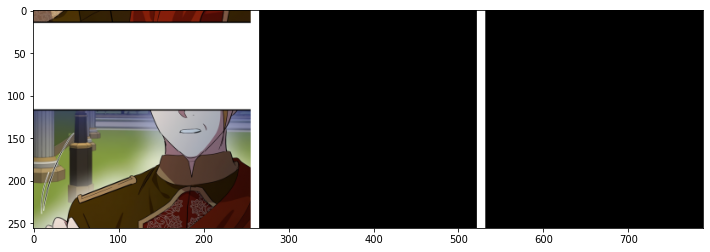

In [ ]:
for i, (x, y) in enumerate(zip(test_x[:30], test_y[:30])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    plt.savefig(data_file_path+ '{}/'.format(save_dir)+r'{:03n}.png'.format(i+1))

In [ ]:
model.save(data_file_path + '{}/'.format(save_dir) + 'my_model')
model.save_weights(data_file_path + '{}/'.format(save_dir) + 'checkpoints/my_checkpoint')
import pickle
with open(data_file_path + '{}/'.format(save_dir) + '/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

dict_keys(['loss', 'dice_coef', 'recall_2', 'precision_2', 'val_loss', 'val_dice_coef', 'val_recall_2', 'val_precision_2', 'lr'])


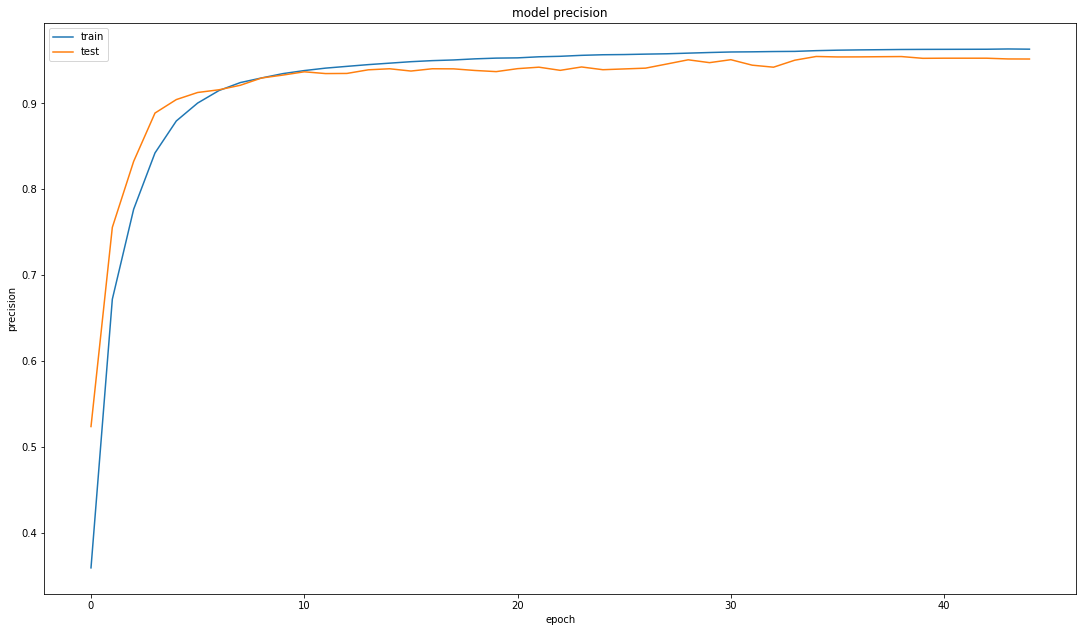

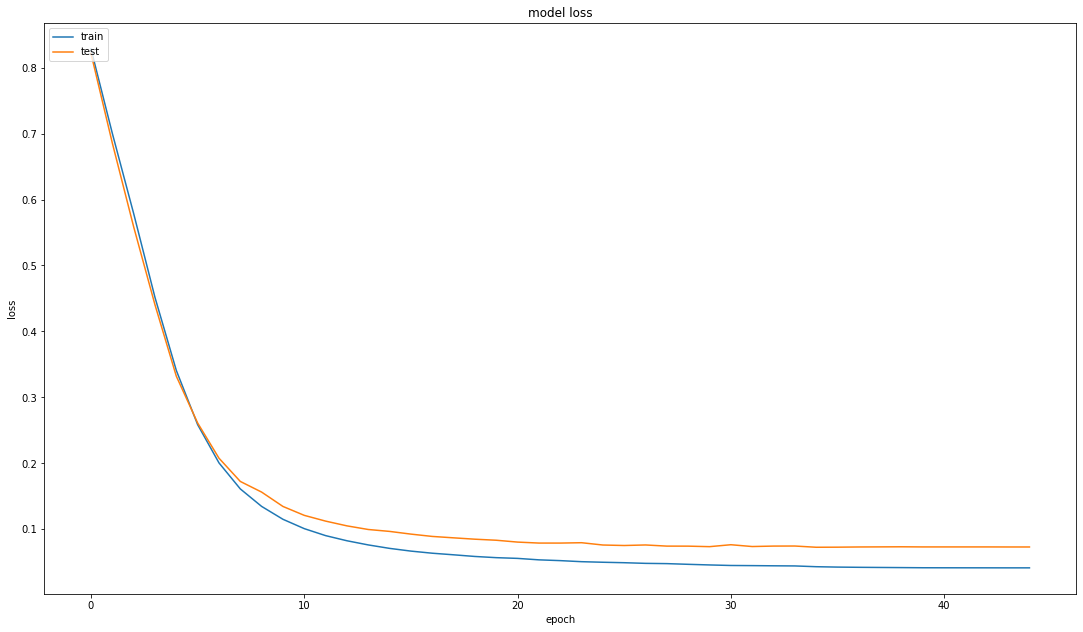

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig(data_file_path+ '{}/'.format(save_dir) +'model_precision_history.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig(data_file_path+ '{}/'.format(save_dir) +'model_loss_history.png')
plt.show()

In [ ]:
test_x

## How to Improve the Results

<ul>
    <li> Use data augmentation </li>
    <li> Use other pretrained encoder </li>
    <li> Use a different decoder or different blocks in the decoder. </li>   
 </ul>

# Thank You

FOLLOW US ON:
<ul>
<li><a href="https://www.youtube.com/idiotdeveloper"> YOUTUBE </a></li>
<li><a href="https://facebook.com/idiotdeveloper"> FACEBOOK </a></li>
<li><a href="https://twitter.com/nikhilroxtomar"> TWITTER </a></li>
<li><a href="https://www.instagram.com/nikhilroxtomar"> INSTAGRAM </a></li>
<li><a href="https://www.patreon.com/idiotdeveloper"> PATREON </a></li>
</ul>

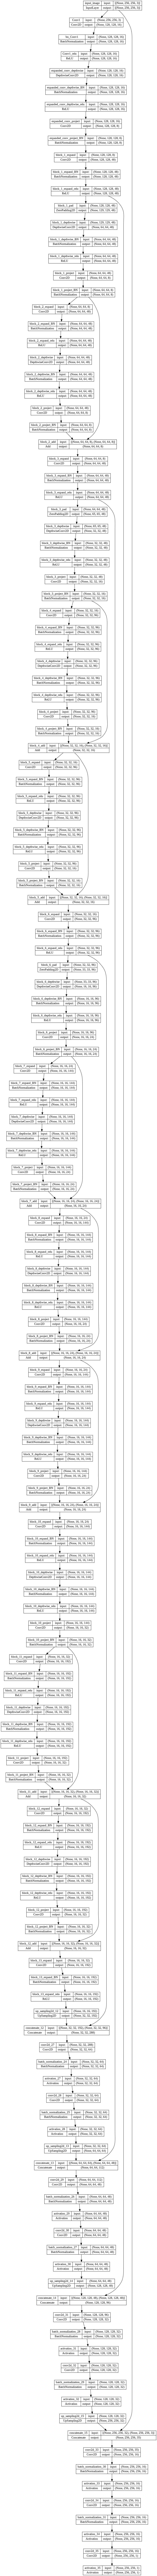

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file=data_file_path+ '{}/'.format(save_dir) +'model_output.png').show() # write and show
visualkeras.layered_view(model, to_file= '/content/model_output.png').show() # write and show


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Current Model inference

/content/drive/My Drive/Signals and Systems Research Project/Example_Original_VLT_116_009.png


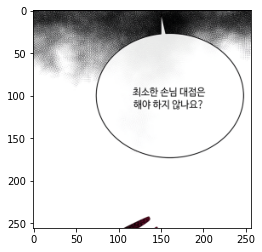

1/1 [==============================] - 0s 21ms/step


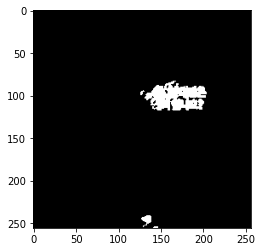

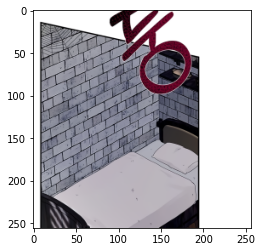

1/1 [==============================] - 0s 22ms/step


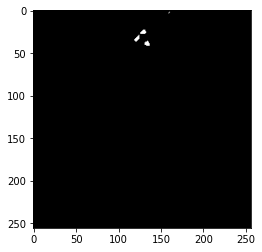

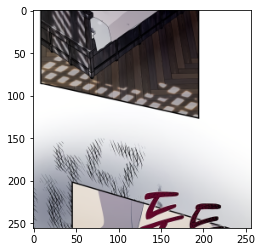

1/1 [==============================] - 0s 20ms/step


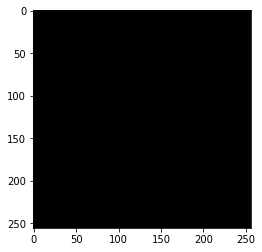

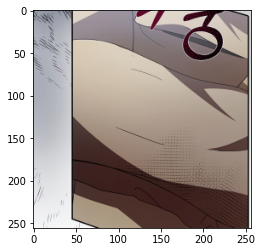

1/1 [==============================] - 0s 21ms/step


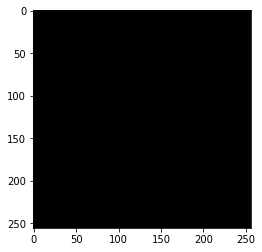

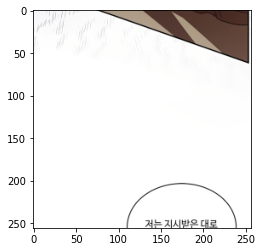

1/1 [==============================] - 0s 22ms/step


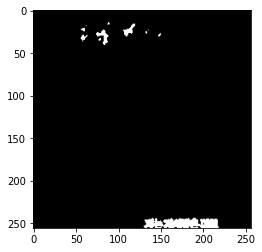

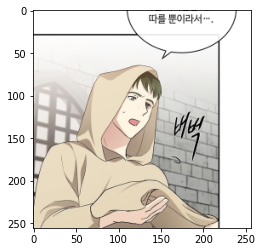

1/1 [==============================] - 0s 21ms/step


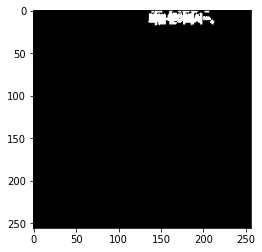

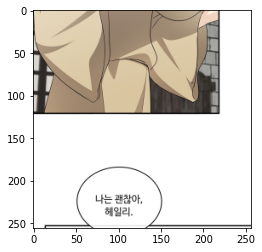

1/1 [==============================] - 0s 20ms/step


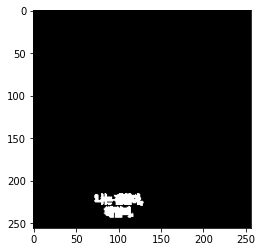

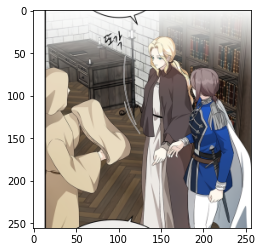

1/1 [==============================] - 0s 25ms/step


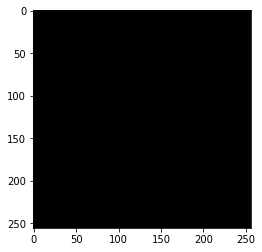

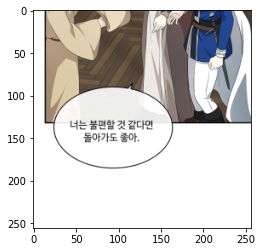

1/1 [==============================] - 0s 21ms/step


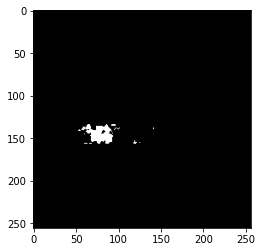

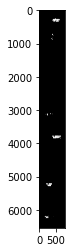

In [ ]:
import math
base_path = '/content/drive/My Drive/Signals and Systems Research Project/'
inference_file_name = 'Example_Original_VLT_90_001.png'
inference_file_name = 'Example_Original_VLT_116_009.png'
# inference_file_path = '/content/drive/My Drive/Signals and Systems Research Project/chaos_pattern_test.png'
# inference_file_path = '/content/drive/My Drive/Signals and Systems Research Project/49_cropped_test.png'
# inference_file_path = '/content/drive/My Drive/Signals and Systems Research Project/Example_Original_VLT_100_11.png'
inference_file_path = base_path + inference_file_name

threshold_prob = 0.5

print(inference_file_path)
#code taken from Image_processing.ipynb
#partition the infer_image into IMAGE_SIZE shaped squares so that the model can run inference on them and stich them back together later
# print('IMAGE_SIZE', IMAGE_SIZE)
infer_image_partition_list = []
infer_image_partition_height_list = []
infer_image_array = cv2.imread(inference_file_path)
infer_image_array = cv2.cvtColor(infer_image_array, cv2.COLOR_BGR2RGB)


infer_img_height = np.shape(infer_image_array)[0]
infer_img_width = np.shape(infer_image_array)[1]
infer_img_dim = (infer_img_width, infer_img_height)
infer_img_slice_num = math.ceil(infer_img_height / infer_img_width)
infer_img_resize_height = round((infer_img_height/ infer_img_width) * IMAGE_SIZE)
infer_img_resize_dim = (IMAGE_SIZE, infer_img_resize_height)
# set datatype to uint8 so that cv2.resize() can work
infer_image_array = np.array(infer_image_array, dtype='uint8')
infer_img_resize = cv2.resize(infer_image_array, infer_img_resize_dim, interpolation = cv2.INTER_AREA)
stitch_mask_list = []
for i in range(infer_img_slice_num):
  if i == (infer_img_slice_num - 1): #try to include portion of previous crop to maintain square IMAGE_SIZE
    infer_crop_img = infer_img_resize[(infer_img_resize_height - IMAGE_SIZE):, :]
    infer_image_partition_height_list.append(infer_img_resize_height - (infer_img_slice_num -1) * IMAGE_SIZE) #portion of height not included in previous crop
  else:
    infer_crop_img = infer_img_resize[IMAGE_SIZE * i : IMAGE_SIZE * (i+1), :]
  plt.imshow(infer_crop_img)
  plt.show()
  if i == 0:
    infer_image_partition_list = np.expand_dims(infer_crop_img, axis=0)
  else:
    infer_image_partition_list = np.append(infer_image_partition_list, np.expand_dims(infer_crop_img, axis=0), axis=0)
  infer_image_partition_list[i] = infer_image_partition_list[i] / 255.0
  y_pred = model.predict(np.expand_dims(infer_image_partition_list[i], axis=0))[0] > threshold_prob #0.5
  process_y_pred = mask_parse(y_pred)

  boolean_to_int = np.vectorize(lambda t: 255 if t == True else 0 )
  int_y_pred = boolean_to_int(process_y_pred)
  plt.imshow(int_y_pred)
  plt.show()
  if i == (infer_img_slice_num - 1):
    height_pixel_count = infer_img_resize_height - (infer_img_slice_num -1) * IMAGE_SIZE #infer_image_partition_height_list[infer_img_slice_num -1]
    #cutoff overlapping pixels
    int_y_pred = int_y_pred[(IMAGE_SIZE-height_pixel_count):, :]
  stitch_mask_list.append(int_y_pred)
stitch_mask_infer_output = cv2.vconcat(stitch_mask_list)
stitch_mask_infer_output = np.array(stitch_mask_infer_output, dtype='uint8') #convert data type so that cv2.resize() works
restored_stitch_mask_infer_output = cv2.resize(stitch_mask_infer_output, infer_img_dim, interpolation=cv2.INTER_CUBIC)
plt.imshow(restored_stitch_mask_infer_output)
plt.imsave(inference_file_path[:-4] +'_inference.png',restored_stitch_mask_infer_output)
plt.imsave('inference.png',restored_stitch_mask_infer_output)

Run inference on input file

In [ ]:
model_weight_path = '/content/drive/My Drive/Signals and Systems Research Project/New_data_processing_result/checkpoints/my_checkpoint'

def u_model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model
loaded_model = u_model()
loaded_model.load_weights(model_weight_path)
# new_model = tf.keras.models.load_model('/content/drive/My Drive/Signals and Systems Research Project/New_data_processing_result/my_model') #did not work due to custom config might need to add dice_coef and dice_loss
# model = new_model



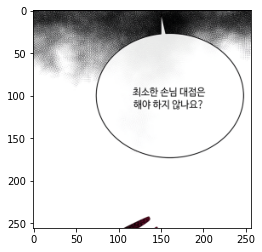

1/1 [==============================] - 0s 19ms/step


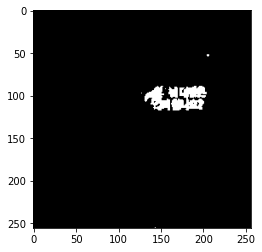

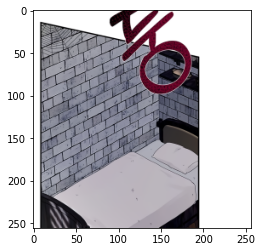

1/1 [==============================] - 0s 35ms/step


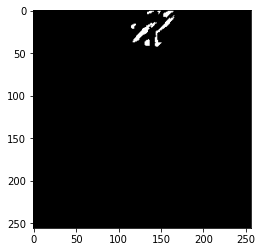

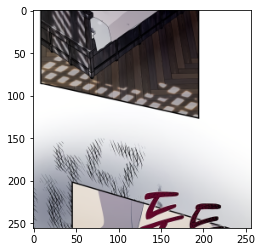

1/1 [==============================] - 0s 21ms/step


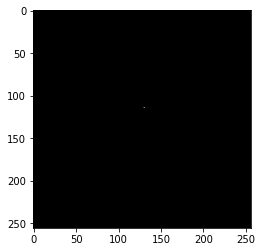

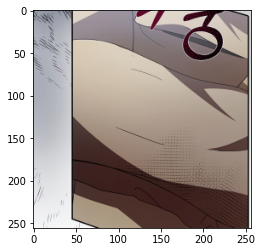

1/1 [==============================] - 0s 19ms/step


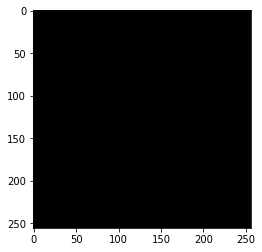

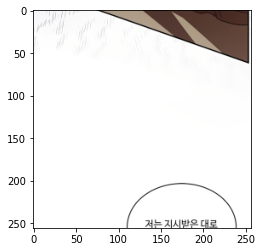

1/1 [==============================] - 0s 21ms/step


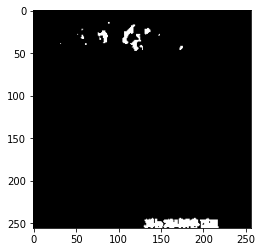

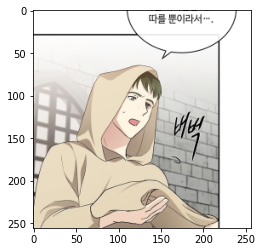

1/1 [==============================] - 0s 30ms/step


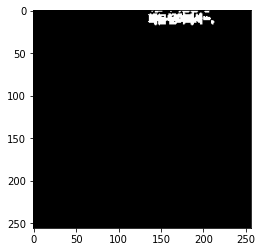

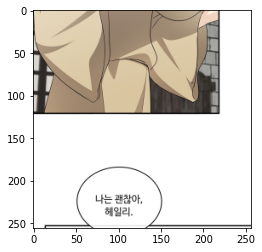

1/1 [==============================] - 0s 20ms/step


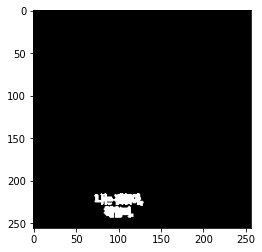

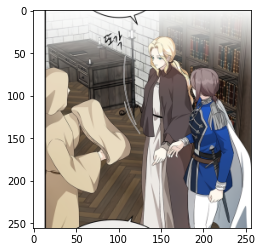

1/1 [==============================] - 0s 19ms/step


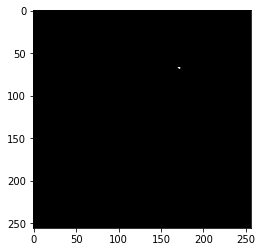

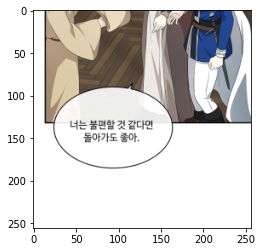

1/1 [==============================] - 0s 19ms/step


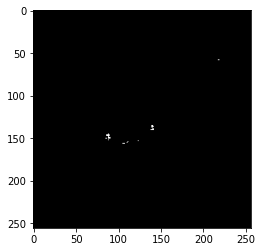

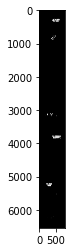

In [ ]:
import math
base_path = '/content/drive/My Drive/Signals and Systems Research Project/'
inference_file_name = 'Example_Original_VLT_90_001.png'
inference_file_name = 'Example_Original_VLT_116_009.png'
# inference_file_path = '/content/drive/My Drive/Signals and Systems Research Project/chaos_pattern_test.png'
# inference_file_path = '/content/drive/My Drive/Signals and Systems Research Project/49_cropped_test.png'
# inference_file_path = '/content/drive/My Drive/Signals and Systems Research Project/Example_Original_VLT_100_11.png'
inference_file_path = base_path + inference_file_name
threshold_prob = 0.5

#code taken from Image_processing.ipynb
#partition the infer_image into IMAGE_SIZE shaped squares so that the model can run inference on them and stich them back together later
# print('IMAGE_SIZE', IMAGE_SIZE)
infer_image_partition_list = []
infer_image_partition_height_list = []
infer_image_array = cv2.imread(inference_file_path)
infer_image_array = cv2.cvtColor(infer_image_array, cv2.COLOR_BGR2RGB)


infer_img_height = np.shape(infer_image_array)[0]
infer_img_width = np.shape(infer_image_array)[1]
infer_img_dim = (infer_img_width, infer_img_height)
infer_img_slice_num = math.ceil(infer_img_height / infer_img_width)
infer_img_resize_height = round((infer_img_height/ infer_img_width) * IMAGE_SIZE)
infer_img_resize_dim = (IMAGE_SIZE, infer_img_resize_height)
# set datatype to uint8 so that cv2.resize() can work
infer_image_array = np.array(infer_image_array, dtype='uint8')
infer_img_resize = cv2.resize(infer_image_array, infer_img_resize_dim, interpolation = cv2.INTER_AREA)
stitch_mask_list = []
for i in range(infer_img_slice_num):
  if i == (infer_img_slice_num - 1): #try to include portion of previous crop to maintain square IMAGE_SIZE
    infer_crop_img = infer_img_resize[(infer_img_resize_height - IMAGE_SIZE):, :]
    infer_image_partition_height_list.append(infer_img_resize_height - (infer_img_slice_num -1) * IMAGE_SIZE) #portion of height not included in previous crop
  else:
    infer_crop_img = infer_img_resize[IMAGE_SIZE * i : IMAGE_SIZE * (i+1), :]
  plt.imshow(infer_crop_img)
  plt.show()
  if i == 0:
    infer_image_partition_list = np.expand_dims(infer_crop_img, axis=0)
  else:
    infer_image_partition_list = np.append(infer_image_partition_list, np.expand_dims(infer_crop_img, axis=0), axis=0)
  infer_image_partition_list[i] = infer_image_partition_list[i] / 255.0
  y_pred = loaded_model.predict(np.expand_dims(infer_image_partition_list[i], axis=0))[0] > threshold_prob #0.5
  process_y_pred = mask_parse(y_pred)

  boolean_to_int = np.vectorize(lambda t: 255 if t == True else 0 )
  int_y_pred = boolean_to_int(process_y_pred)
  plt.imshow(int_y_pred)
  plt.show()
  if i == (infer_img_slice_num - 1):
    height_pixel_count = infer_img_resize_height - (infer_img_slice_num -1) * IMAGE_SIZE #infer_image_partition_height_list[infer_img_slice_num -1]
    #cutoff overlapping pixels
    int_y_pred = int_y_pred[(IMAGE_SIZE-height_pixel_count):, :]
  stitch_mask_list.append(int_y_pred)
stitch_mask_infer_output = cv2.vconcat(stitch_mask_list)
stitch_mask_infer_output = np.array(stitch_mask_infer_output, dtype='uint8') #convert data type so that cv2.resize() works
restored_stitch_mask_infer_output = cv2.resize(stitch_mask_infer_output, infer_img_dim, interpolation=cv2.INTER_CUBIC)
plt.imshow(restored_stitch_mask_infer_output)
plt.imsave(inference_file_path[:-4] +'_old_model_inference.png',restored_stitch_mask_infer_output)
plt.imsave('old_model_inference.png',restored_stitch_mask_infer_output)

Lama Portion (https://github.com/saic-mdal/lama)
Code Source:https://colab.research.google.com/github/saic-mdal/lama/blob/master/colab/LaMa_inpainting.ipynb#scrollTo=RwXRMaNHW4r5

Lama Setup

In [ ]:
#@title Run this sell to set everything up
print('\n> Cloning the repo')
!git clone https://github.com/saic-mdal/lama.git

print('\n> Install dependencies')
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 torchtext==0.9
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet


print('\n> Changing the dir to:')
%cd /content/lama

print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

print('>fixing opencv')
!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.1.2.30 --quiet


print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil



canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

File Name

In [ ]:
fname = None

In [ ]:
#@title Draw a Mask, Press Finish, Wait for Inpainting

if fname is None:
  from google.colab import files
  files = files.upload()
  fname = list(files.keys())[0]
else:
  fname = wget.download(fname)

shutil.rmtree('./data_for_prediction', ignore_errors=True)
!mkdir data_for_prediction

copyfile(fname, f'./data_for_prediction/{fname}')
os.remove(fname)
fname = f'./data_for_prediction/{fname}'

image64 = base64.b64encode(open(fname, 'rb').read())
image64 = image64.decode('utf-8')

print(f'Will use {fname} for inpainting')
img = np.array(plt.imread(f'{fname}')[:,:,:3])

draw(image64, filename=f"./{fname.split('.')[1]}_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
#@title Show a masked image and save a mask
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['figure.dpi'] = 200
plt.subplot(131)
with_mask = np.array(plt.imread(f"./{fname.split('.')[1]}_mask.png")[:,:,:3])
mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('mask')
plt.imsave(f"./{fname.split('.')[1]}_mask.png",mask, cmap='gray')

plt.subplot(132)
img = np.array(plt.imread(f'{fname}')[:,:,:3])
plt.imshow(img)
plt.axis('off')
plt.title('img')

plt.subplot(133)
img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(fname)[:,:,:3])
_=plt.imshow(img)
_=plt.axis('off')
_=plt.title('img * mask')
plt.show()

print('Run inpainting')
if '.jpeg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output dataset.img_suffix=.jpeg > /dev/null
elif '.jpg' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.jpg > /dev/null
elif '.png' in fname:
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_for_prediction outdir=/content/output  dataset.img_suffix=.png > /dev/null
else:
  print(f'Error: unknown suffix .{fname.split(".")[-1]} use [.png, .jpeg, .jpg]')

plt.rcParams['figure.dpi'] = 200
plt.imshow(plt.imread(f"/content/output/{fname.split('.')[1].split('/')[2]}_mask.png"))
_=plt.axis('off')
_=plt.title('inpainting result')
plt.show()
fname = None